# Training base expert on vanilla OGBench environment using BC

In [1]:
import random
import torch
import os
import math

import matplotlib.pyplot as plt

from collections import defaultdict

from causal_gym import AntMazePCH
from causal_rl.algo.imitation.imitate import *
from causal_rl.algo.imitation.finetune import *

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
/home/et2842/miniconda3/envs/causalenv/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# num_steps = 1000
# seed = 0
# hidden_dims = set()

# random.seed(seed)
# torch.manual_seed(seed)

In [4]:
# env = AntMazePCH(num_steps=num_steps, hidden_dims=hidden_dims, seed=seed)
# train_eps = env.expert.num_eps
# train_eps

In [5]:
# X = {f'X{t}' for t in range(num_steps)}
# Y = f'Y{num_steps}'
# obs_prefix = env.env.observed_unobserved_vars[0]

In [6]:
# Z_sets = {}
# for Xi in X:
#     i = int(Xi[1:])
#     cond = set()

#     for j in range(i+1):
#         cond.update({f'{o}{j}' for o in list(set(obs_prefix) - {'X'})})

#     for j in range(i):
#         cond.add(f'X{j}')

#     Z_sets[Xi] = cond

In [7]:
# records = collect_expert_trajectories(
#     env,
#     num_episodes=train_eps,
#     max_steps=num_steps,
#     seed=seed
# )

In [8]:
# hidden_size = 256
# lr = 3e-4
# batch_size = 2048
# patience = 15
# lookback = 1
# num_blocks = 4
# epochs = 100
# dropout = 0.0

# dims = {
#     'P': 3,
#     'O': 4,
#     'A': 8,
#     'L': 3,
#     'T': 3,
#     'J': 8,
#     'X': 8
# }

In [9]:
# model, slots, Z_trim = train_single_policy_long_horizon(
#     records,
#     Z_sets,
#     dims=dims,
#     epochs=epochs,
#     include_vars=obs_prefix,
#     lookback=lookback,
#     continuous=True,
#     num_actions = env.action_space.shape[0],
#     hidden_dim=hidden_size,
#     num_blocks=num_blocks,
#     dropout=dropout,
#     lr=lr,
#     batch_size=batch_size,
#     patience=patience,
#     device=device,
#     seed=seed,
#     action_bounds=(env.action_space.low, env.action_space.high)
# )

# policy = shared_policy_fn_long_horizon(model, slots, Z_trim, continuous=True, device=device)
# policies = make_shared_policy_dict(policy)

In [10]:
# expert_episode_rewards = defaultdict(float)
# for rec in records:
#     ep = rec['episode']
#     expert_episode_rewards[ep] += float(rec['reward'])

# num_eps = len(expert_episode_rewards)
# expert_rewards = [expert_episode_rewards[e] for e in range(num_eps)]

# policy_records = collect_imitator_trajectories(env, policies, num_episodes=num_eps, max_steps=num_steps, seed=seed)
# policy_episode_rewards = defaultdict(float)
# for rec in policy_records:
#     ep = rec['episode']
#     policy_episode_rewards[ep] += float(rec['reward'])

# policy_rewards = [policy_episode_rewards[e] for e in range(num_eps)]
# plt.figure(figsize=(8,5))
# plt.plot(expert_rewards, label='Expert')
# plt.plot(policy_rewards, label='Policy BC')
# plt.xlabel('Episode')
# plt.ylabel('Final Cumulative Reward')
# plt.title('Comparison of Expert Dataset vs. BC Policy Returns')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [11]:
# sum(expert_rewards)/num_eps, sum(policy_rewards)/num_eps

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm

def get_episode_xy_from_records(records, episode_id: int):
    '''
    records: list of dicts from collect_expert_trajectories(...)
    episode_id: which episode to extract

    Returns:
        xs, ys : np.ndarray of shape (T,)
    '''
    # Filter records for that episode, sorted by step
    ep = [r for r in records if r['episode'] == episode_id]
    ep = sorted(ep, key=lambda r: r['step'])

    xs, ys = [], []
    for r in ep:
        # r['info']['hidden_obs']['P'] is a *history* list; last entry is current position
        pos = r['obs']['P'][-1]   # shape (3,)
        xs.append(pos[0])
        ys.append(pos[1])

    return np.array(xs), np.array(ys)

def plot_ant_trajectory_xy(records, episode_id: int = 0, ax=None, title_prefix='AntMaze'):
    '''
    Visualize the ant's 2D trajectory (x, y) for a single episode.

    - Path is colored by time (early=dark, late=bright).
    - Start and end are annotated.
    - Small arrows show direction every few steps.
    '''
    xs, ys = get_episode_xy_from_records(records, episode_id)
    T = len(xs)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        fig = ax.figure

    # Build a colored line collection for the path
    points = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Time as color (0..1)
    t_norm = np.linspace(0, 1, T-1)
    lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(0, 1))
    lc.set_array(t_norm)
    lc.set_linewidth(2.5)
    ax.add_collection(lc)

    # Start and end markers
    ax.scatter(xs[0], xs[0], alpha=0)  # dummy to keep colors aligned if needed
    ax.scatter(xs[0], ys[0], s=80, c='green', marker='o', edgecolors='black', label='Start')
    ax.scatter(xs[-1], ys[-1], s=80, c='red', marker='X', edgecolors='black', label='End')

    # Small arrows every N steps to show direction
    step = max(1, T // 30)  # about ~30 arrows max
    for i in range(0, T-1, step):
        dx = xs[i+1] - xs[i]
        dy = ys[i+1] - ys[i]
        ax.arrow(xs[i], ys[i], dx, dy,
                 length_includes_head=True,
                 head_width=0.2,
                 head_length=0.4,
                 alpha=0.6)

    # Colorbar for time
    cbar = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Time (normalized)')

    ax.set_aspect('equal', 'box')
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    ax.set_title(f'{title_prefix} - Episode {episode_id} trajectory')
    ax.grid(alpha=0.3)
    ax.legend(loc="upper left")

    plt.tight_layout()
    return fig, ax

In [13]:
# fig, ax = plot_ant_trajectory_xy(records, episode_id=0, title_prefix='Expert AntMaze')
# plt.show()

In [14]:
# fig, ax = plot_ant_trajectory_xy(policy_records, episode_id=np.random.randint(0, 1102), title_prefix='Naive AntMaze')
# plt.show()

In [15]:
# # save model for fine-tuning
# import os
# import torch

# SAVE_DIR = '/home/et2842/causal/causalrl/models'
# os.makedirs(SAVE_DIR, exist_ok=True)
# MODEL_PATH = os.path.join(SAVE_DIR, 'antmaze_expert.pt')

# checkpoint = {
#     "state_dict": model.state_dict(),
#     "slots": slots,
#     "Z_trim": Z_trim,
#     "dims": dims,
#     "lookback": lookback,
#     "continuous": True,
#     "num_actions": env.action_space.shape[0],
#     "hidden_dim": hidden_size,
#     "num_blocks": num_blocks,
#     "dropout": 0.0,
#     "layernorm": True,
#     "final_tanh": True,
#     "action_bounds_low": env.action_space.low,
#     "action_bounds_high": env.action_space.high,
#     "input_dim": int(model.hidden.in_features),
# }

# torch.save(checkpoint, MODEL_PATH)
# print("Saved expert to:", MODEL_PATH)

In [16]:
# load model
MODEL_PATH = "/home/et2842/causal/causalrl/models/antmaze_expert.pt"
checkpoint = torch.load(MODEL_PATH, map_location=device)

# Rebuild the model with the same architecture
action_bounds = (checkpoint['action_bounds_low'], checkpoint['action_bounds_high'])

pretrained_actor = ContinuousPolicyNN(
    input_dim=checkpoint['input_dim'],
    action_dim=checkpoint['num_actions'],
    hidden_dim=checkpoint['hidden_dim'],
    num_blocks=checkpoint['num_blocks'],
    dropout=checkpoint['dropout'],
    layernorm=checkpoint['layernorm'],
    final_tanh=checkpoint['final_tanh'],
    action_bounds=action_bounds,
).to(device)

pretrained_actor.load_state_dict(checkpoint['state_dict'])
# pretrained_actor.eval()
pretrained_actor.train()

slots = checkpoint['slots']
Z_trim = checkpoint['Z_trim']
dims = checkpoint['dims']
lookback = checkpoint['lookback']

state_dim = checkpoint['input_dim']
state_dim

/tmp/ipykernel_2010819/3540482843.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


44

In [17]:
# add F to base model input dim
old_state_dim = state_dim
extra_dim = 2 # F

actor_with_F = ContinuousPolicyNN(
    input_dim=old_state_dim + extra_dim,
    action_dim=checkpoint['num_actions'],
    hidden_dim=checkpoint['hidden_dim'],
    num_blocks=checkpoint['num_blocks'],
    dropout=checkpoint['dropout'],
    layernorm=checkpoint['layernorm'],
    final_tanh=checkpoint['final_tanh'],
    action_bounds=action_bounds
).to(device)

# copy weights
with torch.no_grad():
    actor_with_F.hidden.weight[:, :old_state_dim] = pretrained_actor.hidden.weight
    actor_with_F.hidden.weight[:, old_state_dim:] = 0.0  # initialize new weights to zero
    actor_with_F.hidden.bias = pretrained_actor.hidden.bias

    for old_block, new_block in zip(pretrained_actor.blocks, actor_with_F.blocks):
        for old_p, new_p in zip(old_block.parameters(), new_block.parameters()):
            new_p.copy_(old_p)

    actor_with_F.head.weight[:] = pretrained_actor.head.weight
    actor_with_F.head.bias[:] = pretrained_actor.head.bias

pretrained_actor = actor_with_F
pretrained_actor.train()

state_dim = old_state_dim + extra_dim

In [6]:
num_steps = 1000
rl_seed_pretrain = 2014
rl_seed = 90210
hidden_dims = set() # {'W'}
extra_vars = {'F'}

env_pretrain = AntMazePCH(num_steps=num_steps, hidden_dims=hidden_dims, seed=rl_seed_pretrain)
env_train = AntMazePCH(num_steps=num_steps, hidden_dims=hidden_dims, seed=rl_seed)
action_dim = env_train.env.action_space.shape[0]
action_dim

8

In [19]:
# reward shaping
def make_dense_distance_reward(env, use_delta=True, c=1.0):
    goal_xy = env.env._goal_xy

    def reward_fn(obs, reward_env):
        # obs contains full history because history=True
        t = len(obs['P']) - 1

        P_curr = obs['P'][t]
        curr_xy = np.array(P_curr[:2], dtype=np.float64)
        dist_curr = np.linalg.norm(curr_xy - goal_xy)

        if use_delta:
            if t == 0:
                return 0.0
            P_prev = obs['P'][t - 1]
            prev_xy = np.array(P_prev[:2], dtype=np.float64)
            dist_prev = np.linalg.norm(prev_xy - goal_xy)
            return float(c * (dist_prev - dist_curr))
        else:
            return float(-c * dist_curr)

    return reward_fn

reward_fn = make_dense_distance_reward(env_train)

In [20]:
config = OnlineRLConfig(
    total_env_steps=200_000,
    start_steps=10_000,
    max_episode_steps=num_steps,
    batch_size=256,
    gamma=0.99,
    tau=0.005,
    policy_delay=2,
    actor_lr=3e-6,
    critic_lr=3e-4,
    noise_std=0.05,
    hidden_dim_q=256,
    target_policy_noise=0.1,
    target_noise_clip=0.2,
    actor_warmup_steps=30_000,
    bc_reg_lambda=0.1,
    max_grad_norm=1.0
)

In [21]:
# pretrain critics offline
replay_buffer, q1, q2, target_q1, target_q2 = pretrain_critics_offline(
    env=env_pretrain,
    pretrained_actor=pretrained_actor,
    Z_trim=Z_trim,
    slots=slots,
    state_dim=state_dim,
    action_dim=action_dim,
    config=config,
    device=device,
    num_pretrain_steps=100_000,
    pretrain_updates=50_000,
    seed=rl_seed_pretrain,
    reward_shaping_fn=reward_fn,
    extra_vars=extra_vars
)

In [22]:
def callback(stats: dict):
    if stats['episode'] % 1 == 0:
        print(
            f'[Episode {stats["episode"]}] '
            f'steps={stats["env_steps"]}, '
            f'return={stats["return"]:.2f}, '
            f'len={stats["length"]}, '
            f'buffer={stats["buffer_size"]}'
        )

In [23]:
fine_tuned_policy, logs = td3_fine_tune_actor(
    env=env_train,
    actor=pretrained_actor,
    Z_trim=Z_trim,
    slots=slots,
    state_dim=state_dim,
    action_dim=action_dim,
    config=config,
    device=device,
    seed=rl_seed,
    log_callback=callback,
    replay_buffer=replay_buffer,
    initial_q1=q1,
    initial_q2=q2,
    initial_target_q1=target_q1,
    initial_target_q2=target_q2,
    reward_shaping_fn=reward_fn,
    extra_vars=extra_vars
)

ft_pi = shared_policy_fn_long_horizon(fine_tuned_policy, slots, Z_trim, continuous=True, device=device)
ft_policies = make_shared_policy_dict(ft_pi)

[Episode 1] steps=1000, return=0.18, len=1000, buffer=101947
[Episode 2] steps=2000, return=11.98, len=1000, buffer=102947
[Episode 3] steps=2524, return=23.31, len=524, buffer=103471
[Episode 4] steps=3524, return=7.90, len=1000, buffer=104471
[Episode 5] steps=4354, return=24.29, len=830, buffer=105301
[Episode 6] steps=5354, return=5.36, len=1000, buffer=106301
[Episode 7] steps=6354, return=9.10, len=1000, buffer=107301
[Episode 8] steps=7354, return=10.91, len=1000, buffer=108301
[Episode 9] steps=8208, return=22.99, len=854, buffer=109155
[Episode 10] steps=9208, return=9.06, len=1000, buffer=110155
[Episode 11] steps=10208, return=8.43, len=1000, buffer=111155
[Episode 12] steps=11208, return=19.85, len=1000, buffer=112155
[Episode 13] steps=12208, return=-0.48, len=1000, buffer=113155
[Episode 14] steps=13208, return=17.61, len=1000, buffer=114155
[Episode 15] steps=14208, return=22.70, len=1000, buffer=115155
[Episode 16] steps=15208, return=6.79, len=1000, buffer=116155
[Epis

In [ ]:
# # save expert
# import os
# import torch

# SAVE_DIR = '/home/et2842/causal/causalrl/models'
# os.makedirs(SAVE_DIR, exist_ok=True)
# MODEL_PATH = os.path.join(SAVE_DIR, 'antmaze_expert_finetuned.pt')

# checkpoint = {
#     "state_dict": fine_tuned_policy.state_dict(),
#     "slots": slots,
#     "Z_trim": Z_trim,
#     "dims": dims,
#     "lookback": lookback,
#     "continuous": True,
#     "num_actions": env_train.action_space.shape[0],
#     "hidden_dim": config.hidden_dim_q,
#     "num_blocks": checkpoint['num_blocks'],
#     "dropout": 0.0,
#     "layernorm": True,
#     "final_tanh": True,
#     "action_bounds_low": env_train.action_space.low,
#     "action_bounds_high": env_train.action_space.high,
#     "input_dim": int(fine_tuned_policy.hidden.in_features),
# }

# torch.save(checkpoint, MODEL_PATH)
# print("Saved expert to:", MODEL_PATH)

Saved expert to: /home/et2842/causal/causalrl/models/antmaze_expert_finetuned.pt


In [3]:
# remake policies with F (TODO make imitate.py accept extra_vars instead of this)
def make_ft_policies_with_F(model, slots, Z_trim, device, num_steps):
    policies = {}
    for t in range(num_steps):
        def pi_t(obs, t=t):
            state = build_state_feature(obs, t, Z_trim, slots, device, extra_vars=extra_vars)

            with torch.no_grad():
                action = model(state).squeeze(0).cpu().numpy().astype(np.float32)

            return action
        
        policies[f'X{t}'] = pi_t

    return policies

# ft_policies = make_ft_policies_with_F(
#     fine_tuned_policy,
#     slots=slots,
#     Z_trim=Z_trim,
#     device=device,
#     num_steps=num_steps
# )

In [7]:
# load fine tuned model
MODEL_PATH = "/home/et2842/causal/causalrl/models/antmaze_expert_finetuned.pt"
checkpoint = torch.load(MODEL_PATH, map_location=device)

# Rebuild the model with the same architecture
action_bounds = (checkpoint['action_bounds_low'], checkpoint['action_bounds_high'])

finetuned_actor = ContinuousPolicyNN(
    input_dim=checkpoint['input_dim'],
    action_dim=checkpoint['num_actions'],
    hidden_dim=checkpoint['hidden_dim'],
    num_blocks=checkpoint['num_blocks'],
    dropout=checkpoint['dropout'],
    layernorm=checkpoint['layernorm'],
    final_tanh=checkpoint['final_tanh'],
    action_bounds=action_bounds,
).to(device)

finetuned_actor.load_state_dict(checkpoint['state_dict'])
finetuned_actor.eval()

slots = checkpoint['slots']
Z_trim = checkpoint['Z_trim']
dims = checkpoint['dims']
lookback = checkpoint['lookback']

state_dim = checkpoint['input_dim']
state_dim

ft_policies = make_ft_policies_with_F(
    finetuned_actor,
    slots=slots,
    Z_trim=Z_trim,
    device=device,
    num_steps=num_steps
)

/tmp/ipykernel_2121985/3082966008.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


In [9]:
num_eval_eps = 10
env_eval = AntMazePCH(num_steps=num_steps, hidden_dims=hidden_dims)
ft_records = collect_imitator_trajectories(
    env_eval,
    ft_policies,
    num_episodes=num_eval_eps,
    max_steps=num_steps,
    seed=rl_seed + 1,
    show_progress=True
)

len(ft_records)

Starting episode 1/10...
  Episode 1 ended at step 1000 (terminated: False, truncated: True).
Starting episode 2/10...
  Episode 2 ended at step 1000 (terminated: False, truncated: True).
Starting episode 3/10...
  Episode 3 ended at step 340 (terminated: True, truncated: False).
Starting episode 4/10...
  Episode 4 ended at step 1000 (terminated: False, truncated: True).
Starting episode 5/10...
  Episode 5 ended at step 1000 (terminated: False, truncated: True).
Starting episode 6/10...
  Episode 6 ended at step 1000 (terminated: False, truncated: True).
Starting episode 7/10...
  Episode 7 ended at step 1000 (terminated: False, truncated: True).
Starting episode 8/10...
  Episode 8 ended at step 389 (terminated: True, truncated: False).
Starting episode 9/10...
  Episode 9 ended at step 1000 (terminated: False, truncated: True).
Starting episode 10/10...
  Episode 10 ended at step 679 (terminated: True, truncated: False).
Finished collecting imitator trajectories.


8408

In [10]:
ft_episode_returns = defaultdict(float)
for r in ft_records:
    ep = r['episode']
    ft_episode_returns[ep] += float(r['reward'])

ft_returns = [ft_episode_returns[e] for e in range(num_eval_eps)]
ft_returns

[-1176.7998996300978,
 -1179.3979835432626,
 -399.90195457179846,
 -1161.2410158282187,
 -1172.6570115047878,
 -1191.95591524494,
 -1219.19928914832,
 -453.9016541447865,
 -1174.6381079188977,
 -795.6574648343344]

In [ ]:
# plot learning curves
plt.figure(figsize=(8,4))
plt.plot(logs['episode_returns'])
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('TD3 Fine-tuning: Episode returns over time')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
i = 0

In [ ]:
fig, ax = plot_ant_trajectory_xy(ft_records, episode_id=i % 10, title_prefix='Finetuned AntMaze')
plt.show()
i += 1

No clear give-up point detected under current thresholds.


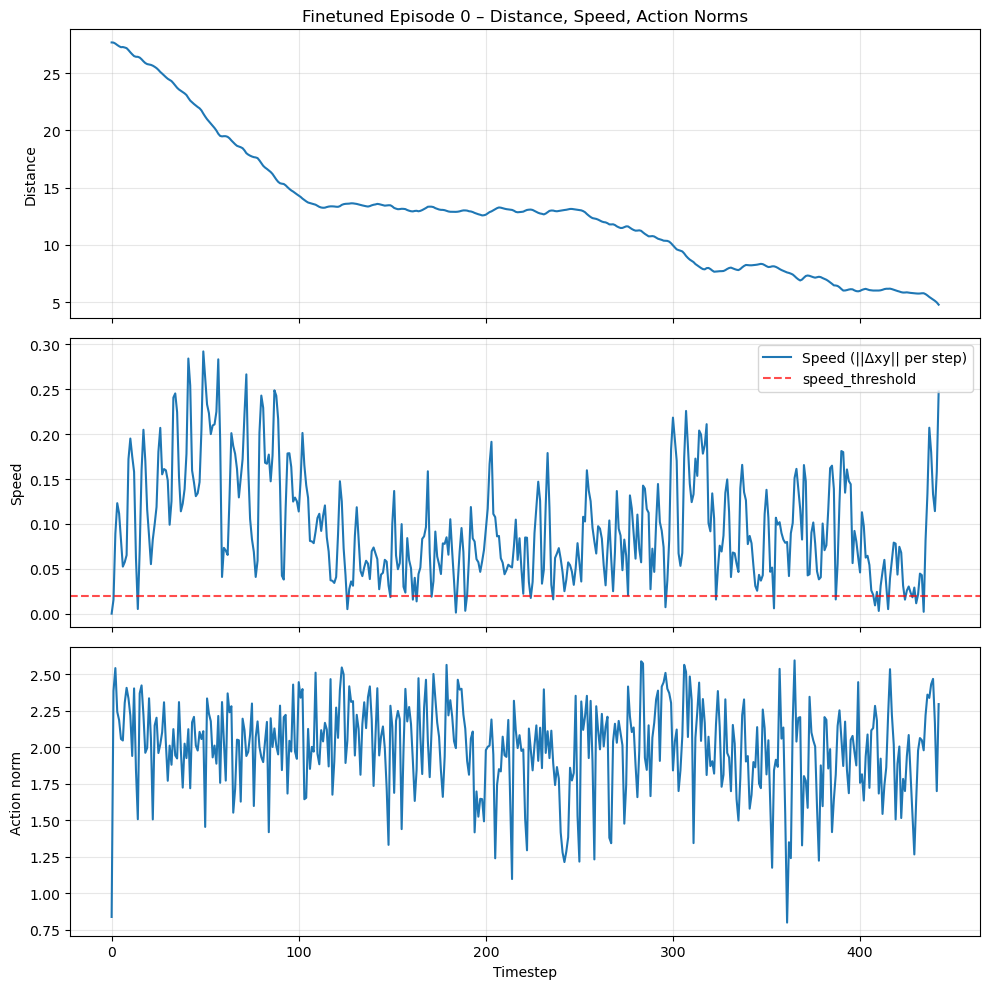

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_ft_episode_giveup(records, episode_id=0, speed_threshold=0.02, tail_fraction=0.3):
    """
    Analyze one episode from ft_records and visualize when the policy 'gives up'.

    Args:
        records: list of dicts from collect_imitator_trajectories(...)
        episode_id: which episode to analyze
        speed_threshold: threshold on ||Δpos|| to consider 'not moving' between steps
        tail_fraction: fraction of the episode tail that must be 'slow' to count as giving up
    """
    # Filter and sort records for this episode
    ep = [r for r in records if r['episode'] == episode_id]
    if len(ep) == 0:
        print(f"No records found for episode {episode_id}")
        return
    
    ep = sorted(ep, key=lambda r: r['step'])
    T = len(ep)
    timesteps = np.arange(T)

    # Extract positions, rewards, actions
    xs, ys = [], []
    rewards = []
    action_norms = []
    for r in ep:
        pos = r['obs']['P'][-1]     # (3,) current position
        xs.append(pos[0])
        ys.append(pos[1])
        rewards.append(r['reward'])

        if 'X' in r['obs'] and len(r['obs']['X']) > 0:
            action = r['obs']['X'][-1]
            action_norms.append(float(np.linalg.norm(action)))
        else:
            action_norms.append(np.nan)

    xs = np.array(xs)
    ys = np.array(ys)
    rewards = np.array(rewards)
    action_norms = np.array(action_norms)

    # Goal position (if available from env_info)
    goal_xy = None
    if 'env_info' in ep[0]['info'] and 'goal' in ep[0]['info']['env_info']:
        goal_xy = np.asarray(ep[0]['info']['env_info']['goal'][:2], dtype=np.float64)
    else:
        # Fall back to default or print a warning
        print("Warning: goal not found in env_info; using (20,20) as default")
        goal_xy = np.array([20.0, 20.0], dtype=np.float64)

    # Distance to goal over time
    pos_xy = np.stack([xs, ys], axis=-1)
    dists = np.linalg.norm(pos_xy - goal_xy, axis=-1)

    # Step-to-step translational speed in XY
    # speed[t] = ||pos[t] - pos[t-1]||, speed[0] = 0
    deltas = pos_xy[1:] - pos_xy[:-1]
    speeds = np.zeros(T)
    speeds[1:] = np.linalg.norm(deltas, axis=-1)

    # Cumulative return (for visual correlation)
    cum_returns = np.cumsum(rewards)

    # --- Detect "give up" point ---
    # We say the policy has 'given up' if, after some step t*, the speed stays
    # below speed_threshold for at least tail_fraction of the episode.
    tail_len = int(T * tail_fraction)
    giveup_step = None

    if tail_len > 0:
        for t in range(T - tail_len):
            tail_speeds = speeds[t:]
            if np.all(tail_speeds < speed_threshold):
                giveup_step = t
                break

    # --- Plotting ---
    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

    # 1) Distance to goal
    axes[0].plot(timesteps, dists, label='Distance to goal')
    axes[0].set_ylabel('Distance')
    axes[0].set_title(f'Finetuned Episode {episode_id} – Distance, Speed, Action Norms')
    axes[0].grid(alpha=0.3)

    # 2) Speed
    axes[1].plot(timesteps, speeds, label='Speed (||Δxy|| per step)')
    axes[1].axhline(speed_threshold, color='r', linestyle='--', alpha=0.7, label='speed_threshold')
    axes[1].set_ylabel('Speed')
    axes[1].grid(alpha=0.3)
    axes[1].legend(loc='upper right')

    # 3) Action norm
    axes[2].plot(timesteps, action_norms, label='||action||')
    axes[2].set_ylabel('Action norm')
    axes[2].set_xlabel('Timestep')
    axes[2].grid(alpha=0.3)

    # Mark give-up step if found
    if giveup_step is not None:
        for ax in axes:
            ax.axvline(giveup_step, color='orange', linestyle='--', alpha=0.8)
        axes[0].text(
            giveup_step, dists[giveup_step],
            '  give up?',
            color='orange',
            va='bottom',
            ha='left',
        )
        print(f"Detected potential give-up step at t = {giveup_step}")
    else:
        print("No clear give-up point detected under current thresholds.")

    plt.tight_layout()
    plt.show()

# Example usage:
analyze_ft_episode_giveup(ft_records, episode_id=0, speed_threshold=0.02, tail_fraction=0.3)